In [38]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

# Definir stop-words
my_stop_words = {
    'to-read', 'closed', 'abandoned-books', 'rating-top', 'literature', 'not-interested', 'libricos', 'recommended',
    '000-next', '001-ladder-top', '002-ladder-short-term', '003-ladder-medium-term', '004-ladder-long-term',
    '005-ladder-maybe-someday', '_cristina', '_giorgia', '_natalia', '_nieves', '_pilar', '_sindy', '_víctor', 'chełmińska'
}
stop_words = set(my_stop_words)
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(stopwords.words('spanish')))
stop_words = stop_words.union(set(stopwords.words('french')))
stop_words = stop_words.union(set(stopwords.words('italian')))

# Función para filtrar stop-words de los textos
def filter_stopwords(text):
    words = text.split()
    return ' '.join(word for word in words if word.lower() not in stop_words)

# 1. Cargar el dataset
df = pd.read_csv('../data/processed/books.csv')

# 2. Limpiar los tags y filtrar stop-words
df['tags_cleaned'] = df['tags'].fillna('').apply(
    lambda x: ' '.join([tag for tag in str(x).split(', ') if tag.lower() not in stop_words])
)
df['text'] = (df['book_title'].fillna('') + '. ' + df['blurb'].fillna('')).apply(filter_stopwords)

In [39]:
# 3. Generar embeddings con SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# 4. Convertir tags en representación numérica (Bag of Words)
vectorizer = CountVectorizer()
tags_vectorized = vectorizer.fit_transform(df['tags_cleaned']).toarray()

# 5. Normalizar embeddings y tags
scaler = StandardScaler()
embeddings_normalized = scaler.fit_transform(embeddings)
tags_normalized = scaler.fit_transform(tags_vectorized)

# 6. Experimentar: Clustering sin tags
X_train, X_test, df_train, df_test = train_test_split(embeddings_normalized, df, test_size=0.2, random_state=42)
kmeans_no_tags = KMeans(n_clusters=5, random_state=42)
kmeans_no_tags.fit(X_train)
df['cluster_no_tags'] = kmeans_no_tags.predict(embeddings_normalized)

# 7. Experimentar: Clustering con tags
combined_features = np.hstack((embeddings_normalized, tags_normalized))
X_train_combined, X_test_combined, df_train_combined, df_test_combined = train_test_split(combined_features, df, test_size=0.2, random_state=42)
kmeans_with_tags = KMeans(n_clusters=5, random_state=42)
kmeans_with_tags.fit(X_train_combined)
df['cluster_with_tags'] = kmeans_with_tags.predict(combined_features)

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


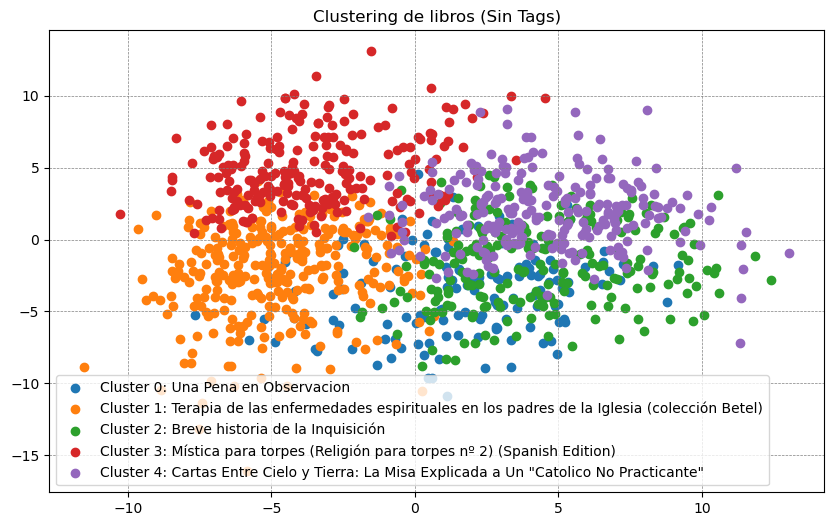

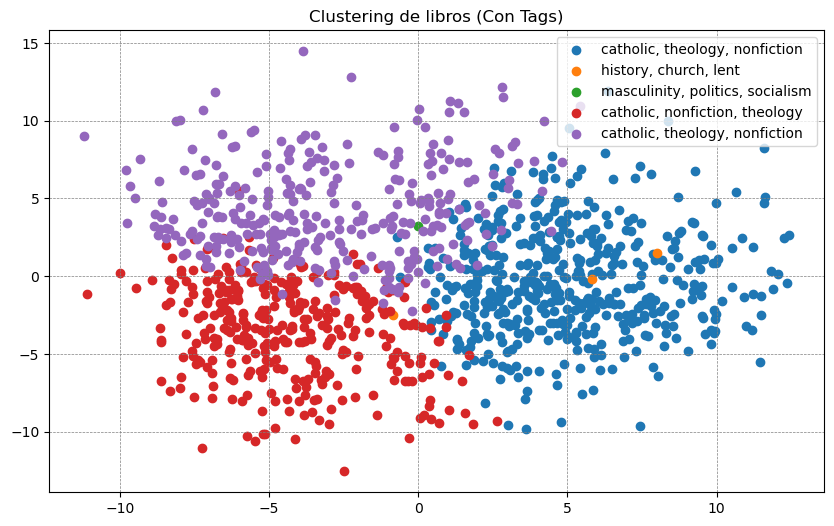

In [40]:
# 10. Asignar nombres significativos a los clusters sin tags basados en el libro más cercano al centroide
def get_cluster_titles(cluster_labels, embeddings, df, n_clusters):
    cluster_titles = []
    for cluster in range(n_clusters):
        # Filtrar los índices de los libros en el cluster actual
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_embeddings = embeddings[cluster_indices]
        cluster_center = cluster_embeddings.mean(axis=0)  # Centroide del cluster
        # Calcular la distancia de cada libro al centroide
        distances = np.linalg.norm(cluster_embeddings - cluster_center, axis=1)
        closest_index = cluster_indices[np.argmin(distances)]  # Índice del libro más cercano al centroide
        cluster_titles.append(df.iloc[closest_index]['book_title'])  # Título del libro más cercano
    return cluster_titles

# Obtener nombres significativos para los clusters sin tags
cluster_titles_no_tags = get_cluster_titles(kmeans_no_tags.labels_, embeddings_normalized, df, n_clusters=5)

# 11. Visualización: Clustering sin tags con nombres significativos
plt.figure(figsize=(10, 6))
for cluster in range(5):
    cluster_points = reduced_embeddings_no_tags[df['cluster_no_tags'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}: {cluster_titles_no_tags[cluster]}')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('Clustering de libros (Sin Tags)')
plt.legend()
plt.savefig('../img/clustering_books_no_tags_named.jpg', dpi=300, bbox_inches='tight')
plt.show()

# 12. Visualización: Clustering con tags con nombres significativos
plt.figure(figsize=(10, 6))
for cluster in range(5):
    cluster_points = reduced_embeddings_with_tags[df['cluster_with_tags'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'{cluster_names_with_tags[cluster]}')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('Clustering de libros (Con Tags)')
plt.legend()
plt.savefig('../img/clustering_books_with_tags_named.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
print(f"Inertia (SSE): {kmeans_no_tags.inertia_}")

Inertia (SSE): 324379.875


In [42]:
# Calcular el Silhouette Score para los datos de entrenamiento
silhouette_no_tags = silhouette_score(X_train, kmeans_no_tags.labels_)
silhouette_with_tags = silhouette_score(X_train_combined, kmeans_with_tags.labels_)

print(f"Silhouette Score (Sin Tags): {silhouette_no_tags}")
print(f"Silhouette Score (Con Tags): {silhouette_with_tags}")

Silhouette Score (Sin Tags): 0.024773987010121346
Silhouette Score (Con Tags): 0.01616811155291561


In [43]:
# Generar etiquetas simuladas (solo para pruebas) para el subconjunto de entrenamiento
df_train['real_labels'] = np.random.randint(0, 5, size=len(df_train))  # 5 categorías simuladas

# Calcular ARI con etiquetas simuladas
ari_no_tags = adjusted_rand_score(df_train['real_labels'], kmeans_no_tags.labels_)
ari_with_tags = adjusted_rand_score(df_train['real_labels'], kmeans_with_tags.labels_)

print(f"Adjusted Rand Index (Sin Tags): {ari_no_tags}")
print(f"Adjusted Rand Index (Con Tags): {ari_with_tags}")

Adjusted Rand Index (Sin Tags): -0.0007803547487096402
Adjusted Rand Index (Con Tags): -0.0010413592775555098


In [44]:
# Generar etiquetas simuladas (solo para pruebas) para el subconjunto de entrenamiento
df_train['real_labels'] = np.random.randint(0, 5, size=len(df_train))  # 5 categorías simuladas

# Calcular NMI con etiquetas simuladas
nmi_no_tags = normalized_mutual_info_score(df_train['real_labels'], kmeans_no_tags.labels_)
nmi_with_tags = normalized_mutual_info_score(df_train['real_labels'], kmeans_with_tags.labels_)

print(f"Normalized Mutual Information (Sin Tags): {nmi_no_tags}")
print(f"Normalized Mutual Information (Con Tags): {nmi_with_tags}")

Normalized Mutual Information (Sin Tags): 0.0056953902225942085
Normalized Mutual Information (Con Tags): 0.007749453163305912


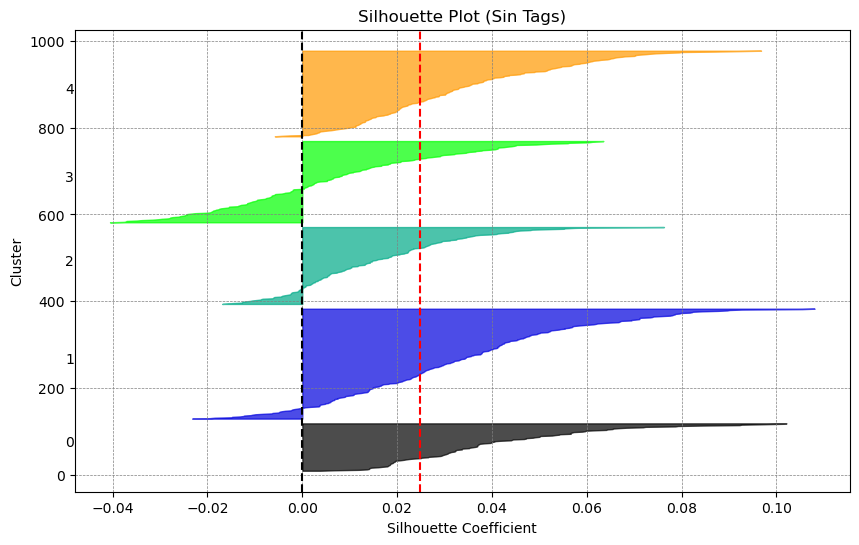

In [45]:
# Silhouette Plot (Sin Tags)
silhouette_values_no_tags = silhouette_samples(X_train, kmeans_no_tags.labels_)

y_lower = 10
plt.figure(figsize=(10, 6))
for i in range(5):  # Número de clusters
    ith_cluster_silhouette_values = silhouette_values_no_tags[kmeans_no_tags.labels_ == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / 5)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot (Sin Tags)")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_values_no_tags.mean(), color="red", linestyle="--")
plt.axvline(x=0, color="black", linestyle="--")
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Añadir grid con rayitas grises discontinuas
plt.savefig('../img/silhouette_plot_no_tags.jpg', dpi=300, bbox_inches='tight')
plt.show()